In [1]:
from ddpm_conditional_64 import Diffusion
from modules_64 import UNet_conditional
device = "cuda"

In [16]:
import torch

def check_cuda_availability():
    if torch.cuda.is_available():
        print("CUDA is available.")
    else:
        print("CUDA is not available.")

check_cuda_availability()


CUDA is available.


In [3]:
model = UNet_conditional(num_classes=10).to(device)


In [4]:
import torch
ckpt = torch.load("./completed_models/ddpm_con_64/ckpt.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [5]:
diffusion = Diffusion(img_size=64, device=device)


this si sigma_min type <class 'float'>
this is sigma_max type <class 'int'>
this is rh0 type <class 'float'>


In [6]:
labels = [5,6,7,8,9] 
label_tensor = torch.tensor(labels).to(device)


In [7]:
import matplotlib.pyplot as plt

def plot_sampled_images(sampled_imgs):
    if sampled_imgs.dim() == 3:  # If there's no batch dimension
        sampled_imgs = sampled_imgs.unsqueeze(0)  # Add batch dimension
    num_images = sampled_imgs.size(0)
    num_cols = 5
    num_rows = num_images // num_cols + 1  # Adjust the number of rows based on the number of images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            if sampled_imgs.size(1) == 1:  # Check if the image is single-channel (grayscale)
                ax.imshow(sampled_imgs[i].squeeze().cpu().numpy(), cmap='gray')
            else:  # If the image has multiple channels (e.g., RGB)
                ax.imshow(sampled_imgs[i].permute(1, 2, 0).cpu().numpy())
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off axes for empty subplots
    plt.tight_layout()
    plt.show()


In [8]:
sigmas = diffusion.beta

In [9]:
print(sigmas)

tensor([0.0100, 0.0101, 0.0101, 0.0102, 0.0103, 0.0103, 0.0104, 0.0105, 0.0105,
        0.0106, 0.0107, 0.0107, 0.0108, 0.0109, 0.0109, 0.0110, 0.0111, 0.0112,
        0.0112, 0.0113, 0.0114, 0.0115, 0.0115, 0.0116, 0.0117, 0.0117, 0.0118,
        0.0119, 0.0120, 0.0121, 0.0121, 0.0122, 0.0123, 0.0124, 0.0124, 0.0125,
        0.0126, 0.0127, 0.0128, 0.0128, 0.0129, 0.0130, 0.0131, 0.0132, 0.0132,
        0.0133, 0.0134, 0.0135, 0.0136, 0.0137, 0.0138, 0.0138, 0.0139, 0.0140,
        0.0141, 0.0142, 0.0143, 0.0144, 0.0145, 0.0145, 0.0146, 0.0147, 0.0148,
        0.0149, 0.0150, 0.0151, 0.0152, 0.0153, 0.0154, 0.0155, 0.0156, 0.0157,
        0.0158, 0.0158, 0.0159, 0.0160, 0.0161, 0.0162, 0.0163, 0.0164, 0.0165,
        0.0166, 0.0167, 0.0168, 0.0169, 0.0170, 0.0172, 0.0173, 0.0174, 0.0175,
        0.0176, 0.0177, 0.0178, 0.0179, 0.0180, 0.0181, 0.0182, 0.0183, 0.0184,
        0.0185, 0.0187, 0.0188, 0.0189, 0.0190, 0.0191, 0.0192, 0.0193, 0.0194,
        0.0196, 0.0197, 0.0198, 0.0199, 

In [10]:
print(sigmas[2].long())

tensor(0, device='cuda:0')


In [11]:
from tqdm import tqdm
def sample(diffusion, model, n, labels, cfg_scale=0.9):
    model.eval()
    with torch.no_grad():
        x = torch.randn((n, 3, diffusion.img_size, diffusion.img_size)).to(diffusion.device)
        for i in tqdm(reversed(range(1, diffusion.noise_steps)), position=3):
            if i > 100:
                continue
            t = (torch.ones(n) * i).long().to(diffusion.device)

            predicted_noise = model(x, t, labels)
            if cfg_scale > 0:
                uncond_predicted_noise = model(x, t, None)
                predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
            alpha = diffusion.alpha[t][:, None, None, None]
            alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
            beta = diffusion.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            x = x.clamp(-1,1)

            if i <= 10:
                if i % 1 == 0:
                    tmp_x = (x.clamp(-1, 1) + 1) / 2
                    tmp_x = (tmp_x * 255).type(torch.uint8)
                    plot_sampled_images(tmp_x)

    model.train()
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

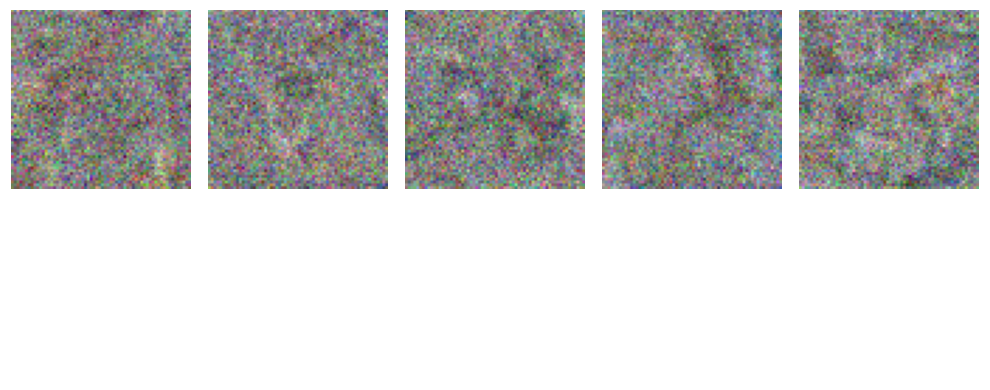

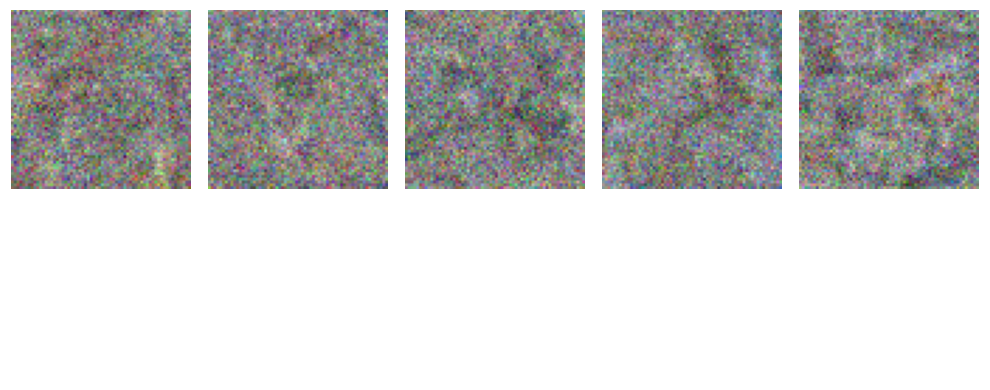

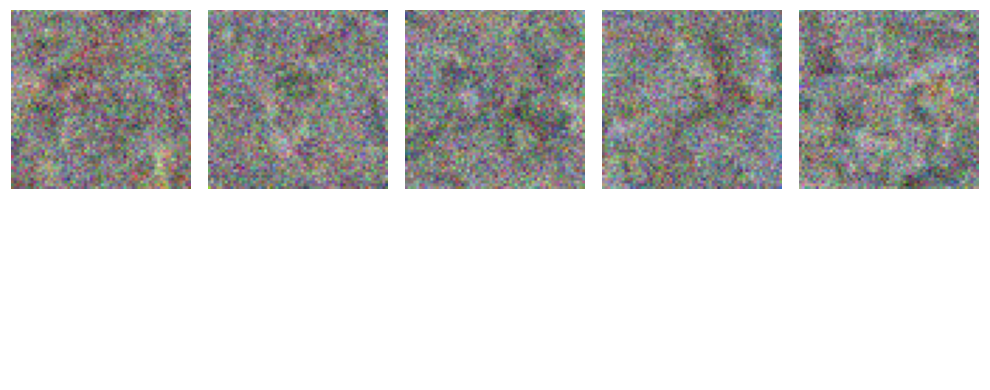

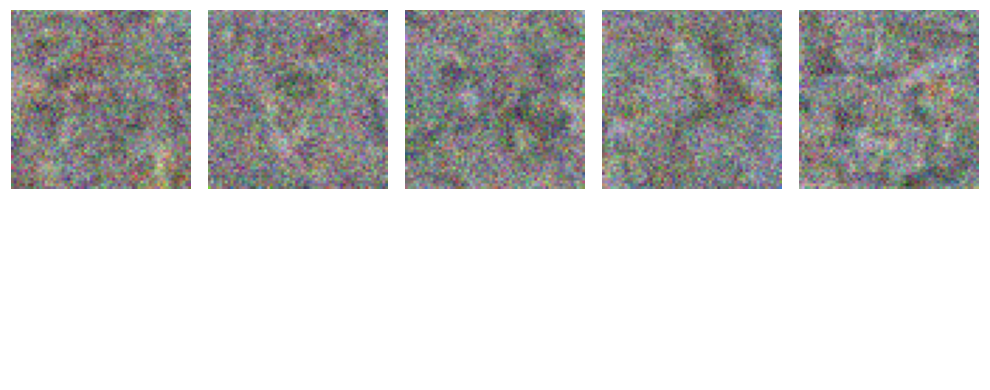

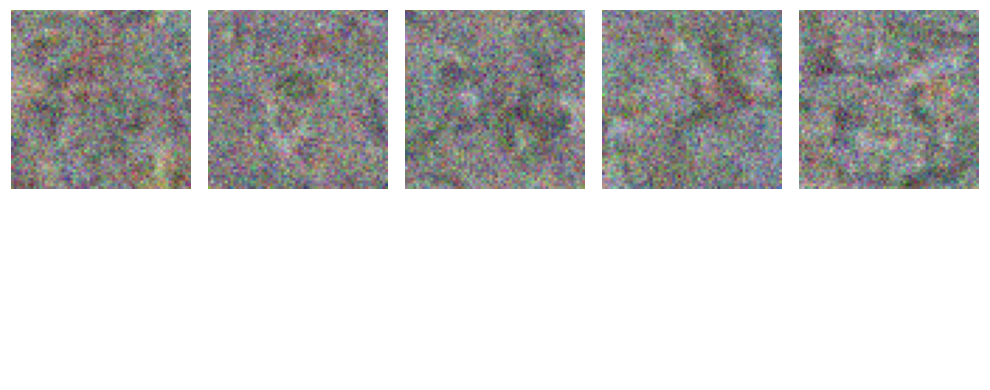

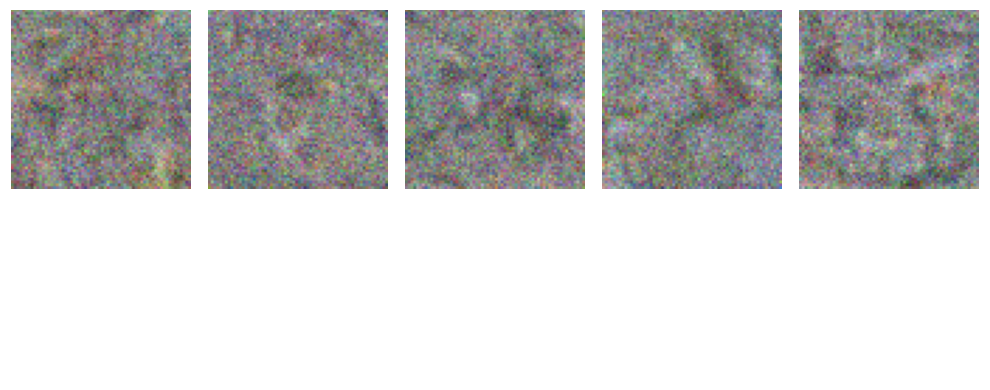

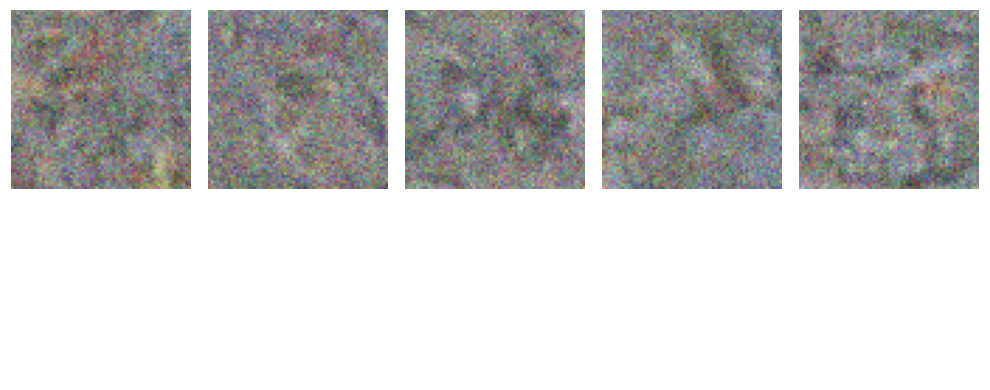

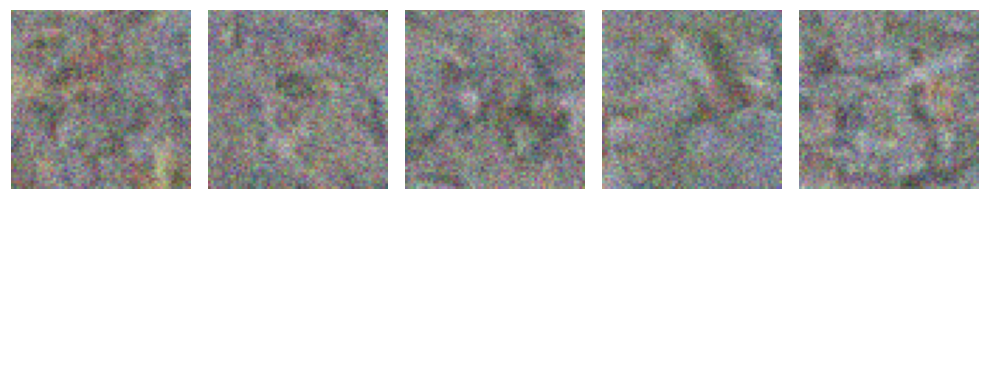

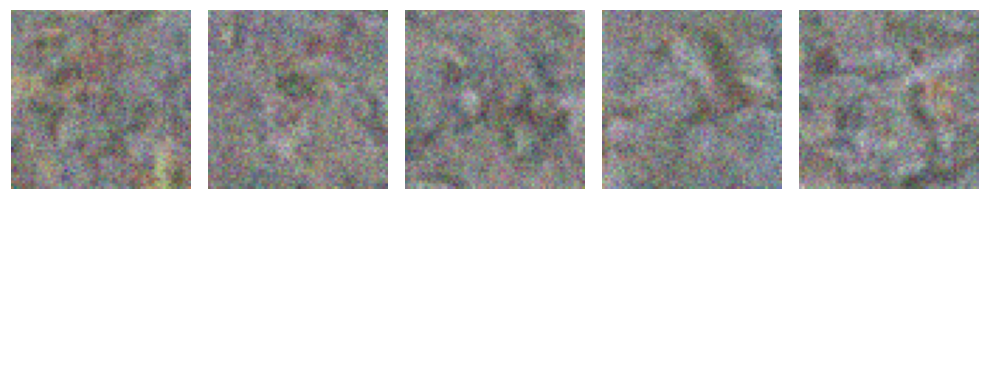

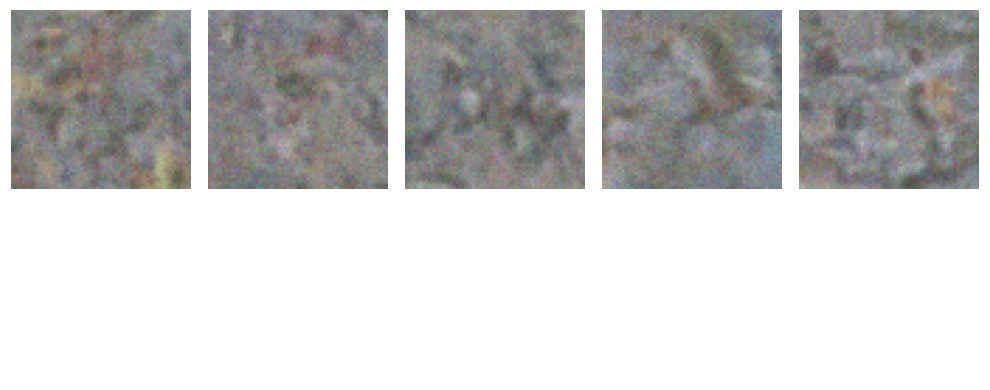

999it [00:19, 51.55it/s]  


In [12]:
sampled_imgs = sample(diffusion, model, n = len(label_tensor), labels = label_tensor)

In [13]:
import os
from PIL import Image
import numpy as np

def save_images(images, save_dir='sampled_images'):
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
    
    for idx, img in enumerate(images):
        img = img.permute(1, 2, 0).squeeze().cpu().numpy()
        img = (img * 255).astype(np.uint8)  # Ensure the pixel values are in the correct range
        img = Image.fromarray(img, mode='RGB')  # Assuming RGB images
        img.save(os.path.join(save_dir, f"final_img{idx}.png"))

# Example usage
save_images(sampled_imgs, save_dir='sampled_images')


In [14]:
print(label_tensor)

tensor([5, 6, 7, 8, 9], device='cuda:0')


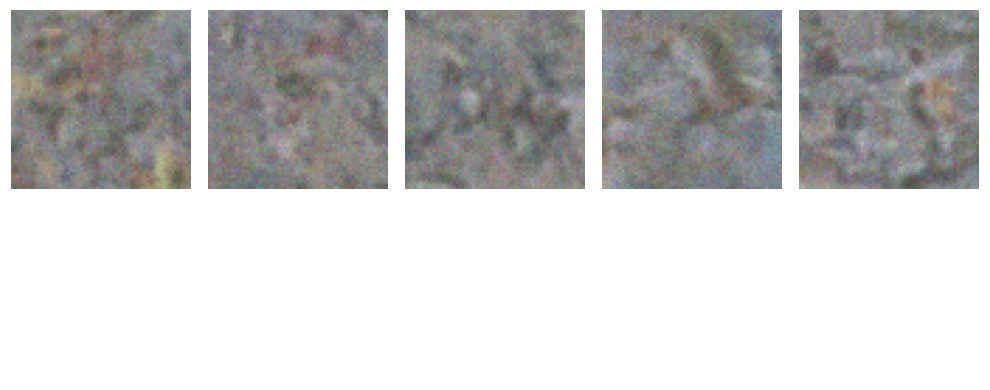

In [15]:
plot_sampled_images(sampled_imgs)